# Seasonality, Holiday Effects, And Regressors (Tính thời vụ, hiệu ứng ngày lễ và các yếu tố hồi quy)

## Modeling Holidays and Special Events (Mô hình hóa theo ngày lễ và các sự kiện đặc biệt)

Nếu bạn có các ngày lễ hoặc các sự kiện định kỳ khác mà bạn muốn lập mô hình, thì bạn phải tạo một khung dữ liệu cho chúng. Nó có hai cột (`holiday` và `ds`) và một hàng cho mỗi lần xuất hiện của ngày lễ. Nó phải bao gồm tất cả các lần xuất hiện của kỳ nghỉ, cả trong quá khứ (dữ liệu lịch sử trở lại) và trong tương lai (xa như dự báo đang được thực hiện). Nếu chúng không lặp lại trong tương lai, Prophet sẽ lập mô hình cho chúng và sau đó không đưa chúng vào dự báo

Bạn cũng có thể bao gồm các cột `lower_window` và `upper_window` kéo dài kỳ nghỉ ra `[lower_window, upper_window]` ngày xung quanh ngày đó. Ví dụ: nếu bạn muốn bao gồm Đêm Giáng sinh trong Giáng sinh, bạn sẽ bao gồm `lower_window=-1,upper_window=0`. Nếu bạn muốn sử dụng Black friday Lễ tạ ơn, bạn sẽ bao gồm `lower_window=0,upper_window=1`. Bạn cũng có thể bao gồm một cột `prior_scale` để đặt riêng tỷ lệ trước cho từng ngày lễ, như được mô tả bên dưới.

Ở đây, chúng tôi tạo một khung dữ liệu bao gồm ngày của tất cả các lần xuất hiện trong trận play-off của Peyton Manning:

In [12]:
import pandas as pd
from prophet import Prophet

df=pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

In [21]:
playoffs=pd.DataFrame({
    'holiday':'playoff',
    'ds':pd.to_datetime(['2008-01-13', '2009-01-03','2010-01-16',
                         '2010-01-24', '2010-02-07', '2011-01-08',
                         '2013-01-12', '2014-01-12','2014-01-19',
                         '2014-02-02', '2015-01-11', '2016-01-17',
                         '2016-01-24', '2016-02-07']),
    'lower_window':0,
    'upper_window':1,
})
superbowls=pd.DataFrame({
    'holiday':'superbowl',
    'ds':pd.to_datetime(['2010-02-07','2014-02-02','2016-02-07']),
    'lower_window':0,
    'upper_window':1,
})
holidays=pd.concat((playoffs,superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


Ở trên, chúng tôi đã bao gồm những ngày diễn ra trận đấu siêu hạng như cả trận đấu loại trực tiếp và trận đấu siêu cúp. Điều này có nghĩa là hiệu ứng siêu cup sẽ là một phần thưởng bổ sung thêm cho hiệu ứng loại trực tiếp.

Sau khi bảng được tạo, các hiệu ứng ngày lễ được đưa vào dự báo bằng cách chuyển chúng vào cùng với đối số `holiday`. Ở đây chúng tôi làm điều đó với dữ liệu Peyton Manning từ [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html):

In [22]:
m=Prophet(holidays=holidays)
m.fit(df)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)

20:52:31 - cmdstanpy - INFO - Chain [1] start processing
20:52:32 - cmdstanpy - INFO - Chain [1] done processing


Hiệu ứng ngày lễ có thể được nhìn thấy ở dataframe `forecast`

In [26]:
forecast[(forecast['playoff']+forecast['superbowl']).abs()>0][
    ['ds','playoff','superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.223262,1.211292
2191,2014-02-03,1.902333,1.457759
2532,2015-01-11,1.223262,0.000000
2533,2015-01-12,1.902333,0.000000
2901,2016-01-17,1.223262,0.000000
2902,2016-01-18,1.902333,0.000000
2908,2016-01-24,1.223262,0.000000
2909,2016-01-25,1.902333,0.000000
2922,2016-02-07,1.223262,1.211292
2923,2016-02-08,1.902333,1.457759


Các hiệu ứng kỳ nghỉ cũng sẽ xuất hiện trong biểu đồ thành phần, nơi chúng tôi thấy rằng có sự tăng đột biến vào những ngày xung quanh các trận đấu diễn ra, với mức tăng đột biến đặc biệt lớn đối với superbowl:

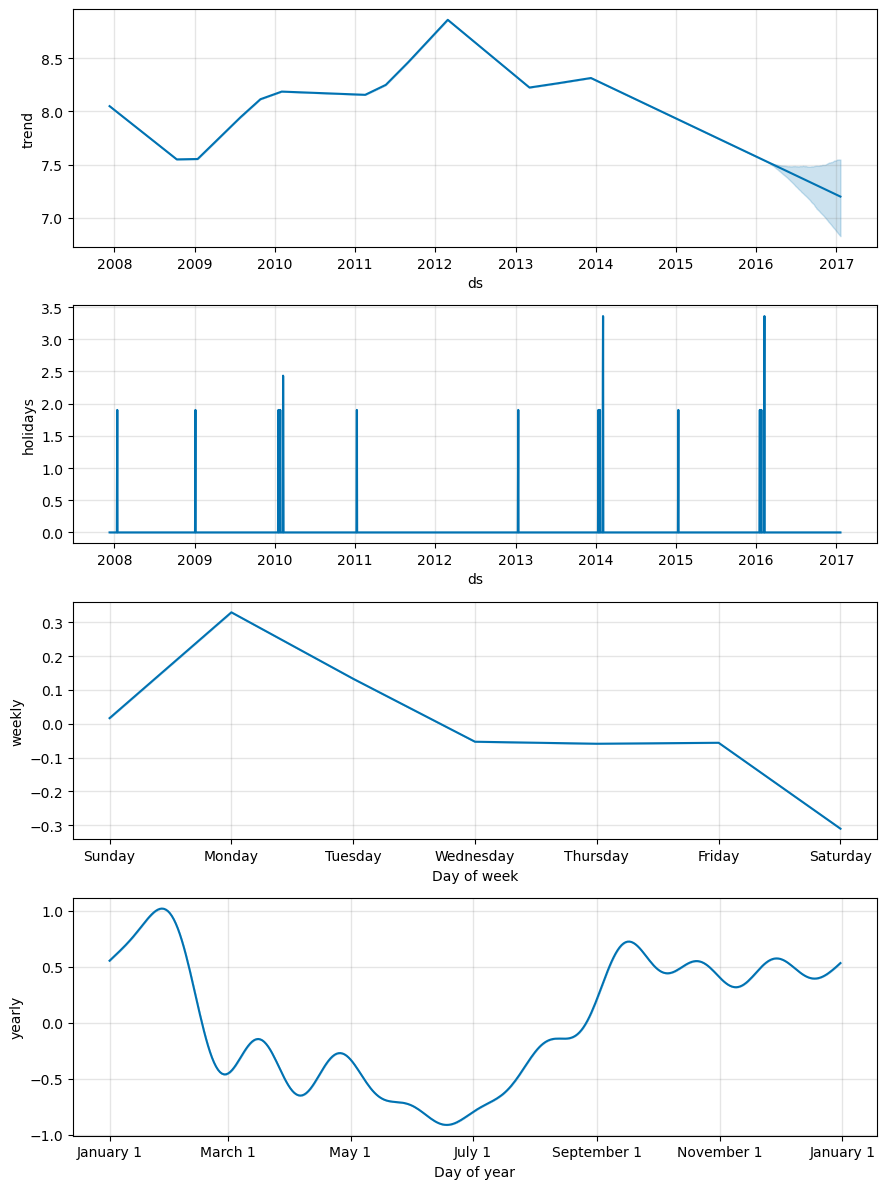

In [27]:
fig=m.plot_components(forecast)

Các ngày lễ riêng lẻ có thể được vẽ bằng cách sử dụng hàm `plot_forecast_component` (import từ `prophet.plot` trong Python) như `plot_forecast_component(m, forecast, 'superbowl')` để chỉ vẽ thành phần ngày lễ superbowl.

## Built-in Country Holidays (Ngày lễ quốc gia tích hợp)

Bạn có thể sử dụng bộ sưu tập tích hợp sẵn các ngày lễ theo quốc gia cụ thể bằng cách sử dụng phương thức `add_country_holidays` (Python) hoặc hàm (R). Tên của quốc gia được chỉ định và sau đó các ngày lễ lớn của quốc gia đó sẽ được đưa vào cùng với bất kỳ ngày lễ nào được chỉ định thông qua đối số `holidays` được mô tả ở trên:

In [28]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

20:59:09 - cmdstanpy - INFO - Chain [1] start processing
20:59:10 - cmdstanpy - INFO - Chain [1] done processing


Bạn có thể biết ngày lễ nào được đưa vào bằng cách xem thuộc tính `train_holiday_names` (Python) hoặc `train.holiday.names` (R) của mô hình:

In [29]:
m.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

Các ngày lễ cho mỗi quốc gia được cung cấp bởi gói `holidays` trong Python. Danh sách các quốc gia khả dụng và tên quốc gia sẽ sử dụng có sẵn trên trang của họ: https://github.com/dr-prodigy/python-holidays. Ngoài các quốc gia đó, Prophet bao gồm các ngày lễ cho các quốc gia này: Brazil (BR), Indonesia (ID), Ấn Độ (IN), Malaysia (MY), Việt Nam (VN), Thái Lan (TH), Philippines (PH), Pakistan ( PK), Bangladesh (BD), Ai Cập (EG), Trung Quốc (CN) và Nga (RU), Hàn Quốc (KR), Belarus (BY) và Các Tiểu vương quốc Ả Rập Thống nhất (AE).

Trong Python, hầu hết các ngày lễ được tính toán một cách xác định và do đó có sẵn cho bất kỳ phạm vi ngày nào; một cảnh báo sẽ được đưa ra nếu ngày nằm ngoài phạm vi được quốc gia đó hỗ trợ. Trong R, ngày nghỉ lễ được tính từ năm 1995 đến năm 2044 và được lưu trữ trong gói dưới dạng `data-raw/generated_holidays.csv`. Nếu cần phạm vi ngày rộng hơn, tập lệnh này có thể được sử dụng để thay thế tệp đó bằng phạm vi ngày khác: https://github.com/facebook/prophet/blob/main/python/scripts/generate_holidays_file.py.

Như trên, các ngày lễ cấp quốc gia sau đó sẽ hiển thị trong biểu đồ thành phần:

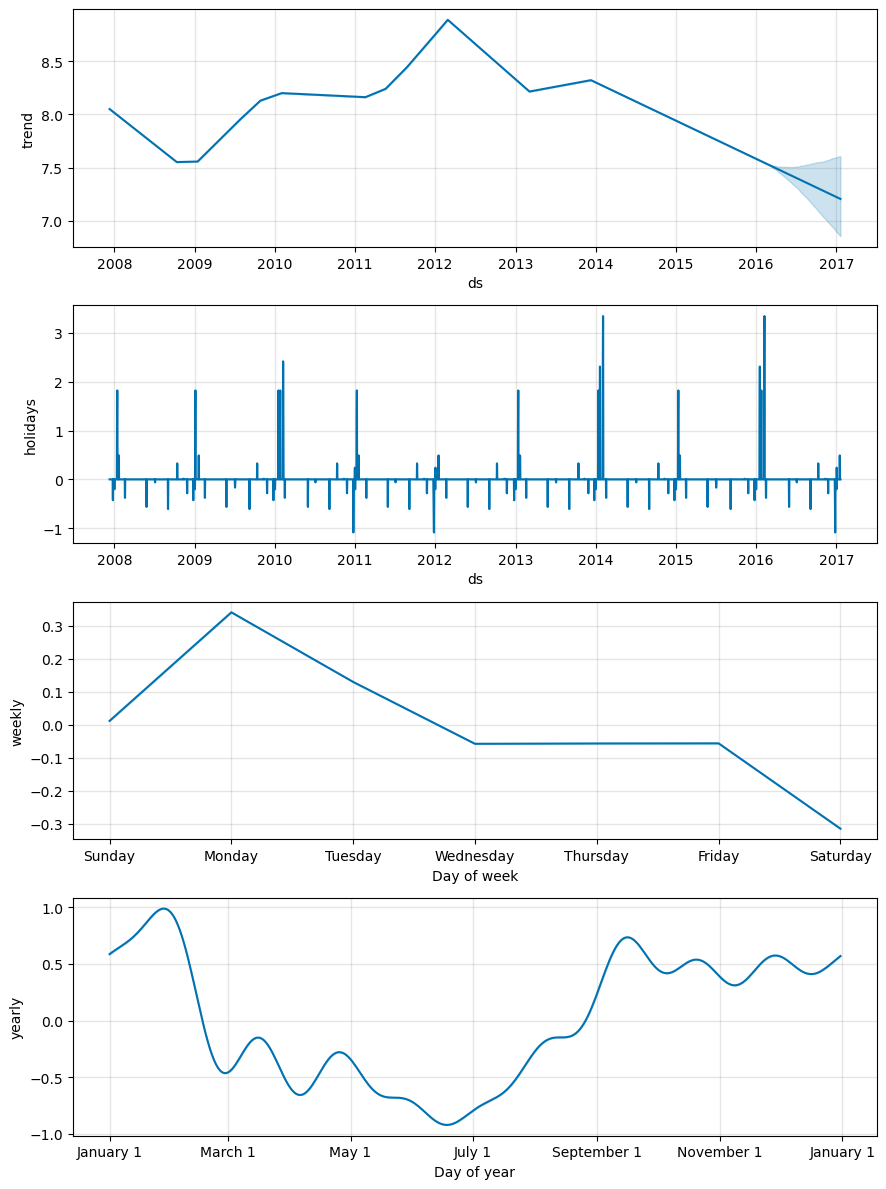

In [30]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

## Fourier Order for Seasonalities (Thứ tự Fourier cho tính thời vụ)

Tính thời vụ được ước tính bằng cách sử dụng tổng Fourier một phần. Xem [bài báo](https://peerj.com/preprints/3190/) để biết chi tiết đầy đủ và [cài đặt này trên Wikipedia](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg) để minh họa về cách tổng Fourier một phần có thể ước tính một tín hiệu định kỳ tùy ý. Số lượng các thuật ngữ trong tổng một phần (thứ tự) là một tham số xác định tốc độ thay đổi của tính thời vụ. Để minh họa điều này, hãy xem xét dữ liệu Peyton Manning từ [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). Thứ tự Fourier mặc định cho tính thời vụ hàng năm là 10, tạo ra sự phù hợp này:

21:10:41 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing


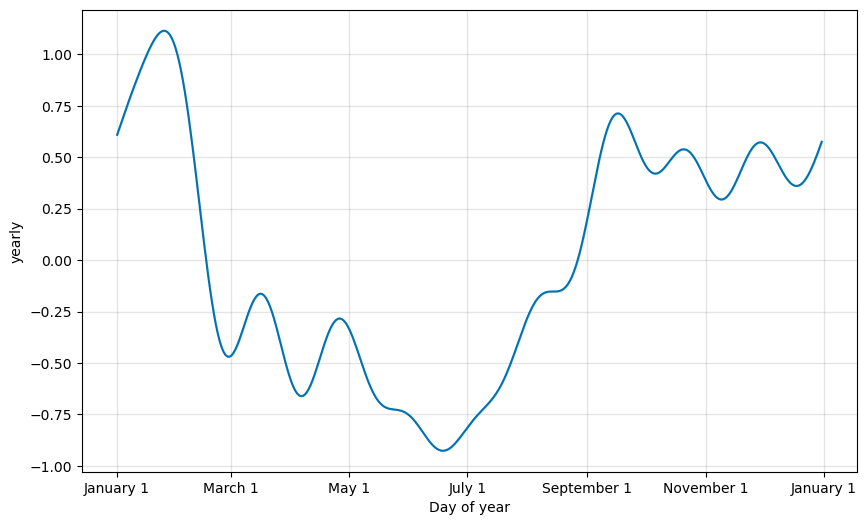

In [31]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

Các giá trị mặc định thường phù hợp nhưng chúng có thể được tăng lên khi tính thời vụ cần phù hợp với những thay đổi có tần suất cao hơn và nhìn chung kém mượt mà hơn. Thứ tự Fourier có thể được chỉ định cho mỗi tính thời vụ tích hợp khi khởi tạo mô hình, ở đây nó được tăng lên 20:

21:12:17 - cmdstanpy - INFO - Chain [1] start processing
21:12:19 - cmdstanpy - INFO - Chain [1] done processing


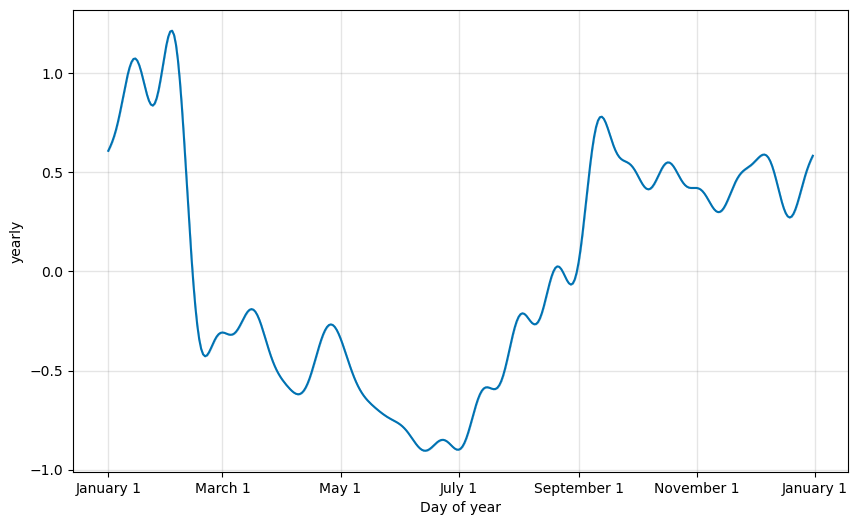

In [32]:
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

Việc tăng số lượng thuật ngữ Fourier cho phép tính thời vụ phù hợp với các chu kỳ thay đổi nhanh hơn, nhưng cũng có thể dẫn đến quá khớp: N thuật ngữ Fourier tương ứng với 2N biến được sử dụng để lập mô hình chu kỳ

## Specifying Custom Seasonalities (Chỉ định thời vụ tùy chỉnh)

Prophet theo mặc định sẽ fit với thời vụ hàng tuần và hàng năm, nếu chuỗi thời gian dài hơn hai chu kỳ. Nó cũng sẽ phù hợp với tính thời vụ hàng ngày cho chuỗi thời gian phụ hàng ngày. Bạn có thể thêm các thời vụ khác (hàng tháng, hàng quý, hàng giờ) bằng cách sử dụng phương thức `add_seasonality` (Python) hoặc hàm (R).

Đầu vào cho chức năng này là tên, khoảng thời gian tính theo ngày và thứ tự Fourier cho tính thời vụ. Để tham khảo, theo mặc định, Tiên tri sử dụng bậc Fourier là 3 cho tính thời vụ hàng tuần và 10 cho tính thời vụ hàng năm. Đầu vào tùy chọn cho `add_seasonality` là thang đo trước cho thành phần theo mùa đó - điều này được thảo luận bên dưới.

Ví dụ: ở đây chúng tôi điều chỉnh dữ liệu Peyton Manning từ [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html), nhưng thay thế tính thời vụ hàng tuần bằng tính thời vụ hàng tháng. Tính thời vụ hàng tháng sau đó sẽ xuất hiện trong biểu đồ thành phần:

21:19:37 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1] done processing


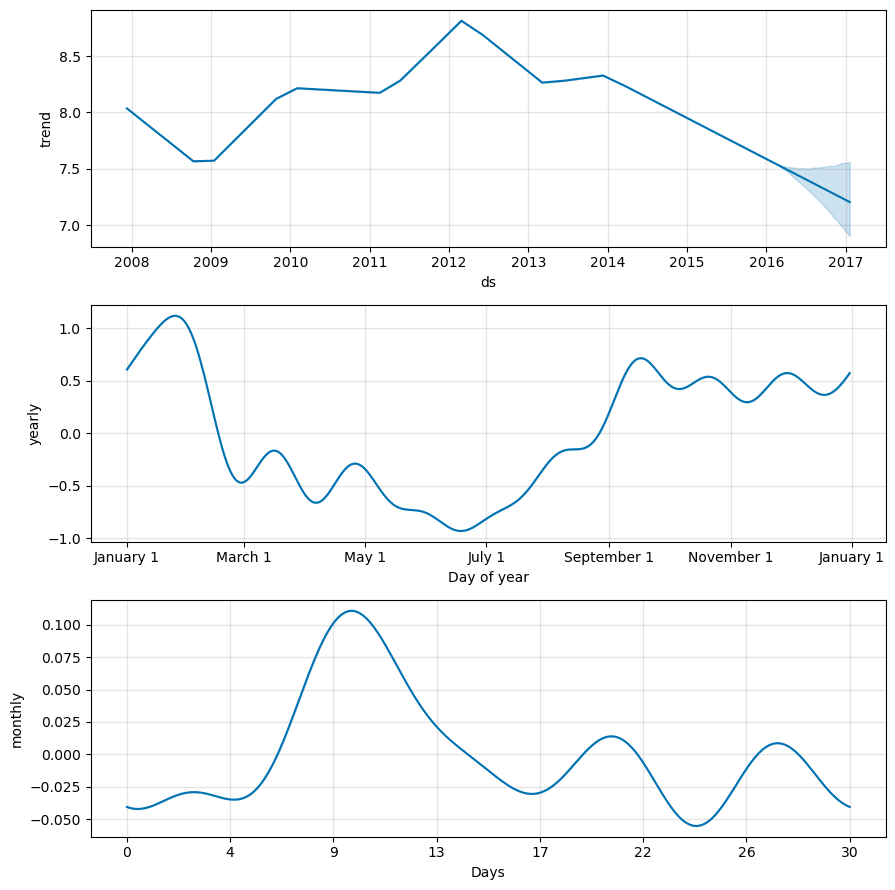

In [33]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

## Seasonalities that depend on other factors (Thời vụ phụ thuộc vào các yếu tố khác)

Trong một số trường hợp, tính thời vụ có thể phụ thuộc vào các yếu tố khác, chẳng hạn như mô hình theo mùa hàng tuần khác vào mùa hè so với các thời điểm còn lại trong năm hoặc mô hình theo mùa hàng ngày khác vào cuối tuần so với các ngày trong tuần. Các loại tính thời vụ này có thể được mô hình hóa bằng cách sử dụng tính thời vụ có điều kiện.

Hãy xem xét ví dụ về Peyton Manning từ [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). Tính thời vụ hàng tuần mặc định giả định rằng mô hình tính thời vụ hàng tuần giống nhau trong suốt cả năm, nhưng chúng tôi cho rằng mô hình thời vụ hàng tuần sẽ khác trong thời gian on-season(khi có các trận đấu vào mỗi Chủ nhật) và off-season. Chúng ta có thể sử dụng các thời vụ có điều kiện để xây dựng các thời vụ hàng tuần để phân biệt off-season và on-season.

Trước tiên, chúng tôi thêm một cột boolean vào khung dữ liệu cho biết mỗi ngày là on-season hay off-season:

In [35]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

,ds,y,on_season,off_season
0,2007-12-10,9.590761,True,False
1,2007-12-11,8.519590,True,False
2,2007-12-12,8.183677,True,False
3,2007-12-13,8.072467,True,False
4,2007-12-14,7.893572,True,False
...,...,...,...,...
2900,2016-01-16,7.817223,True,False
2901,2016-01-17,9.273878,True,False
2902,2016-01-18,10.333775,True,False
2903,2016-01-19,9.125871,True,False


Sau đó, chúng tôi vô hiệu hóa thời vụ hàng tuần được tích hợp sẵn và thay thế bằng hai thời vụ hàng tuần có các cột này được chỉ định làm điều kiện. Điều này có nghĩa là tính thời vụ sẽ chỉ được áp dụng cho những ngày mà cột `condition_name` là `True`. Chúng tôi cũng phải thêm cột vào dataframe trong `future` mà chúng tôi đang đưa ra dự đoán.

21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing


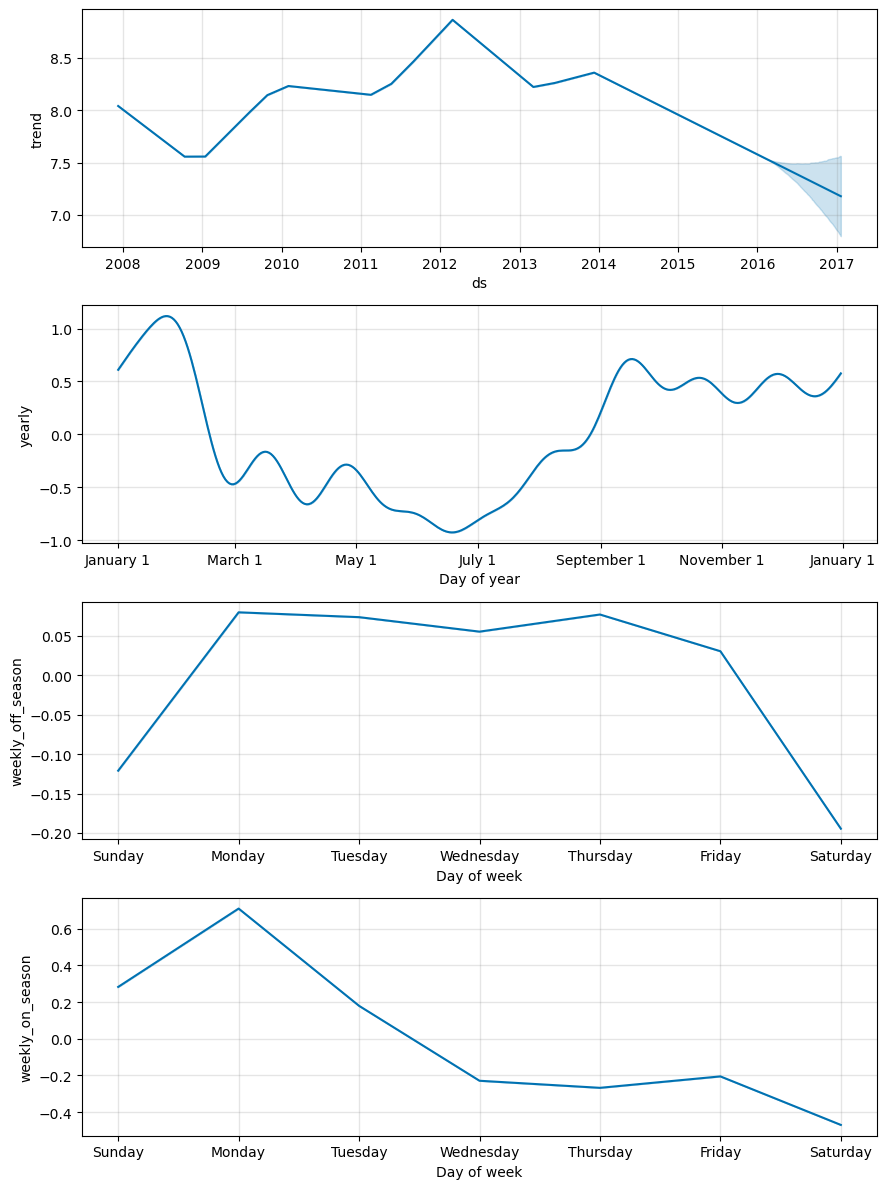

In [36]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

## Prior scale for holidays and seasonality (Quy mô ưu tiên cho các ngày lễ và thời vụ)

Nếu bạn thấy rằng các ngày lễ đang bị quá khớp, bạn có thể điều chỉnh tỷ lệ trước đó của chúng để làm mịn chúng bằng cách sử dụng tham số `holidays_prior_scale`. Theo mặc định, tham số này là 10, cung cấp rất ít sự chính quy hóa. Giảm tham số này làm giảm hiệu ứng kỳ nghỉ:

In [37]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

21:33:55 - cmdstanpy - INFO - Chain [1] start processing
21:33:56 - cmdstanpy - INFO - Chain [1] done processing


,ds,playoff,superbowl
2190,2014-02-02,1.202529,0.984932
2191,2014-02-03,1.852912,1.000421
2532,2015-01-11,1.202529,0.000000
2533,2015-01-12,1.852912,0.000000
2901,2016-01-17,1.202529,0.000000
2902,2016-01-18,1.852912,0.000000
2908,2016-01-24,1.202529,0.000000
2909,2016-01-25,1.852912,0.000000
2922,2016-02-07,1.202529,0.984932
2923,2016-02-08,1.852912,1.000421


Mức độ của hiệu ứng kỳ nghỉ đã giảm so với trước đây, đặc biệt là đối với superbowls, thứ có ít quan sát nhất. Có một tham số `seasonity_prior_scale` điều chỉnh tương tự mức độ mà mô hình thời vụ sẽ phù hợp với dữ liệu.

Các thang đo trước có thể được đặt riêng cho các ngày lễ riêng lẻ bằng cách bao gồm một cột `prior_scale` trong datafram ngày lễ. Các thang đo trước cho các tính thời vụ riêng lẻ có thể được chuyển thành đối số cho `add_seasonality`. Chẳng hạn, có thể đặt thang đo trước cho tính thời vụ hàng tuần bằng cách sử dụng:

In [38]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)

## Additional regressors (Bổ sung hồi quy)

Các biến hồi quy bổ sung có thể được thêm vào phần tuyến tính của mô hình bằng cách sử dụng phương thức hoặc hàm `add_regressor`. Một cột có giá trị biến hồi quy sẽ cần phải có mặt trong cả dataframe của fitting và dự predict. Ví dụ: chúng ta có thể thêm hiệu ứng bổ sung vào Chủ nhật trong mùa giải NFL. Trên biểu đồ thành phần, hiệu ứng này sẽ hiển thị trong biểu đồ 'extra_regressors':


21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing


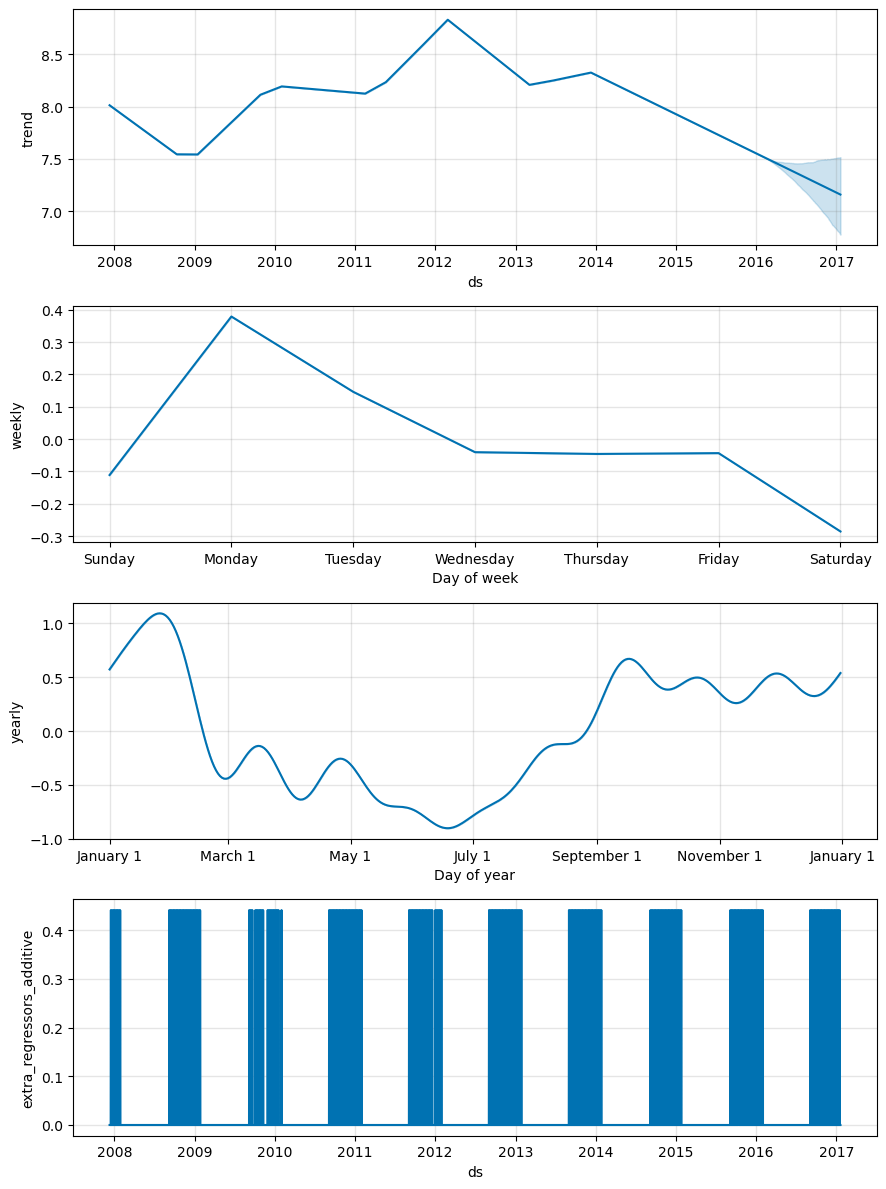

In [39]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

Các Chủ nhật của NFL cũng có thể được xử lý bằng cách sử dụng giao diện "ngày lễ" được mô tả ở trên, bằng cách tạo danh sách các Chủ nhật của NFL trong quá khứ và tương lai. Hàm `add_regressor` cung cấp một giao diện tổng quát hơn để xác định các biến hồi quy tuyến tính bổ sung và đặc biệt không yêu cầu biến hồi quy phải là một chỉ báo nhị phân. Một chuỗi thời gian khác có thể được sử dụng như một biến hồi quy, mặc dù các giá trị tương lai của nó sẽ phải được biết trước.

[Notebook này](https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb)cho thấy một ví dụ về việc sử dụng các yếu tố thời tiết làm biến hồi quy bổ sung trong dự báo mức sử dụng xe đạp và cung cấp một minh họa tuyệt vời về cách có thể đưa các chuỗi thời gian khác vào làm biến hồi quy bổ sung.

Hàm `add_regressor` có các đối số tùy chọn để chỉ định prior scale (prior scale ngày lễ được sử dụng theo mặc định) và liệu trình hồi quy có được chuẩn hóa hay không - xem chuỗi tài liệu với h`elp(Prophet.add_regressor)` trong Python và `?add_regressor` trong R. Lưu ý rằng các biến hồi quy phải được thêm vào trước khi fitting mô hình. Prophet cũng sẽ đưa ra một lỗi nếu biến hồi quy không đổi trong suốt lịch sử, vì không có gì phù hợp với nó.

Biến hồi quy bổ sung phải được biết cho cả lịch sử và các ngày trong tương lai. Do đó, nó phải là thứ gì đó đã biết các giá trị trong tương lai (chẳng hạn như `nfl_sunday`) hoặc thứ gì đó đã được dự báo riêng ở nơi khác. Các biến hồi quy thời tiết được sử dụng trong notebook được liên kết ở trên là một ví dụ điển hình về một biến hồi quy bổ sung có các dự báo có thể được sử dụng cho các giá trị trong tương lai. Người ta cũng có thể sử dụng một chuỗi thời gian khác làm biến hồi quy đã được dự báo bằng mô hình chuỗi thời gian, chẳng hạn như Prophet. Chẳng hạn, nếu `r(t)` được đưa vào làm biến hồi quy cho `y(t)`, Prophet có thể được sử dụng để dự báo `r(t)` và sau đó dự báo đó có thể được đưa vào làm giá trị tương lai khi dự báo `y(t)`. Một lưu ý thận trọng xung quanh phương pháp này: Điều này có thể sẽ không hữu ích trừ khi `r(t)` bằng cách nào đó dễ dự báo hơn `y(t)`. Điều này là do lỗi trong dự báo của `r(t)` sẽ tạo ra lỗi trong dự báo của `y(t)`. Một cài đặt mà điều này có thể hữu ích là trong chuỗi thời gian phân cấp, trong đó có dự báo cấp cao nhất có tín hiệu nhiễu cao hơn và do đó dễ dự báo hơn. Dự báo của nó có thể được đưa vào dự báo cho từng chuỗi cấp thấp hơn.

Các biến hồi quy bổ sung được đưa vào thành phần tuyến tính của mô hình, do đó, mô hình cơ bản là chuỗi thời gian phụ thuộc vào biến hồi quy bổ sung dưới dạng hệ số cộng hoặc hệ số nhân (xem phần tiếp theo về hệ số nhân).

## Coefficients of additional regressors (Hệ số của các biến hồi quy bổ sung)

Để trích xuất các hệ số beta của các biến hồi quy bổ sung, hãy sử dụng hàm tiện ích `regressor_coefficients (from prophet.utilities import regressor_coefficients `trong Python, `prophet:regressor_coefficients` trong R) trên mô hình đã fit. Hệ số beta ước tính cho mỗi biến giải thích đại diện cho mức tăng của giá trị dự đoán đối với mức tăng đơn vị của giá trị biến giải thích (lưu ý rằng các hệ số được trả về luôn theo tỷ lệ của dữ liệu gốc). Nếu `mcmc_samples` được chỉ định, thì một khoảng tin cậy cho mỗi hệ số cũng được trả về, điều này có thể giúp xác định xem mỗi biến hồi quy có “có ý nghĩa thống kê” hay không.